In [1]:
from ardac_utils import *
import matplotlib.pyplot as plt

In [2]:
#use ardac helper functions to grab some fire zone polygons and output a geodataframe in 3338
#and get flammability data for those polygons
fz_gdf = get_area_gdf_by_category("fire_zones", 3338)
fz_data = get_data_for_gdf_polygons(fz_gdf, "flammability")

Bad request, no flammability data for FIRE10: Southwest Area...trying next polygon...


<Axes: >

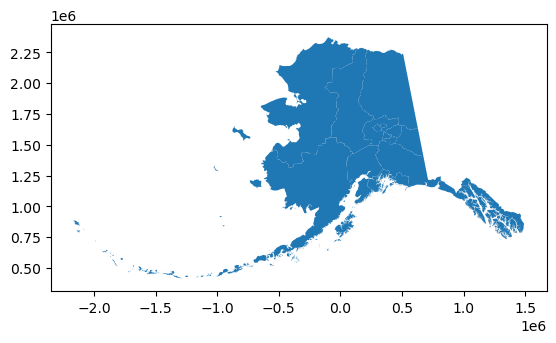

In [3]:
#check out the data
fz_gdf.plot()

In [4]:
fz_data.head()

,id,name,date_range,model,scenario,mean
0,FIRE1,Anchorage/Mat-Su Area,1950-1979,MODEL-SPINUP,historical,0.0003
1,FIRE1,Anchorage/Mat-Su Area,1980-2008,MODEL-SPINUP,historical,0.0004
2,FIRE1,Anchorage/Mat-Su Area,2010-2039,5modelAvg,rcp45,0.0027
3,FIRE1,Anchorage/Mat-Su Area,2010-2039,5modelAvg,rcp60,0.0008
4,FIRE1,Anchorage/Mat-Su Area,2010-2039,5modelAvg,rcp85,0.0011


In [5]:
#subset the data for plotting:
#include just the 5-model avg, and just RCP 8.5
plot_subset = fz_data[(fz_data['model'] == '5modelAvg') & (fz_data['scenario'] == 'rcp85')]
plot_subset.head()

,id,name,date_range,model,scenario,mean
4,FIRE1,Anchorage/Mat-Su Area,2010-2039,5modelAvg,rcp85,0.0011
22,FIRE1,Anchorage/Mat-Su Area,2040-2069,5modelAvg,rcp85,0.0035
40,FIRE1,Anchorage/Mat-Su Area,2070-2099,5modelAvg,rcp85,0.0047
4,FIRE2,Chugach National Forest,2010-2039,5modelAvg,rcp85,0.0000
22,FIRE2,Chugach National Forest,2040-2069,5modelAvg,rcp85,0.0000


In [6]:
#merge with the geodataframe using the area id
plot_gdf = fz_gdf.merge(plot_subset, how='left', on='id')

/home/UA/jdpaul3/mambaforge/envs/atmospheric_rivers/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/home/UA/jdpaul3/mambaforge/envs/atmospheric_rivers/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/home/UA/jdpaul3/mambaforge/envs/atmospheric_rivers/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


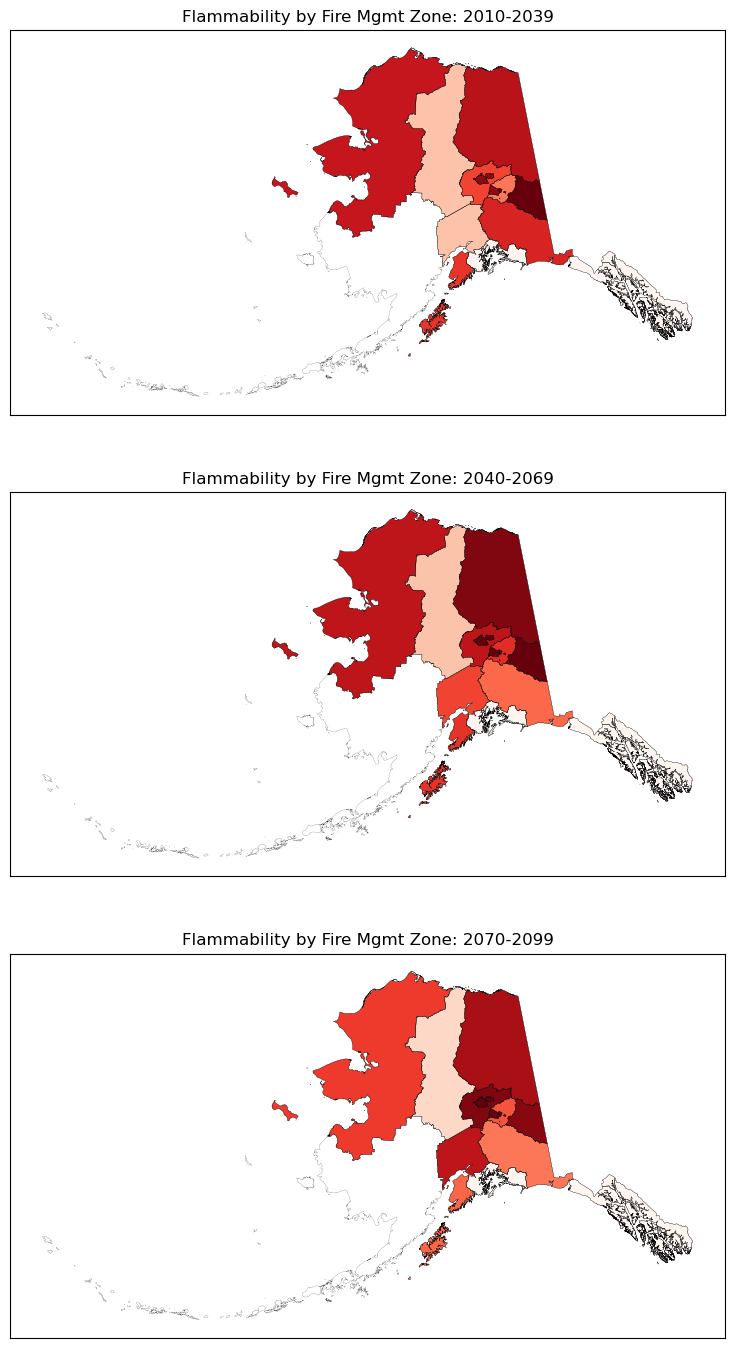

In [7]:
#plot
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,14))

plot_gdf.boundary.plot(color='black', linewidth=0.1, ax=ax1)
plot_gdf[plot_gdf['date_range'] == '2010-2039'].plot(column='mean', cmap='Reds', ax=ax1)

plot_gdf.boundary.plot(color='black', linewidth=0.1, ax=ax2)
plot_gdf[plot_gdf['date_range'] == '2040-2069'].plot(column='mean', cmap='Reds', ax=ax2)

plot_gdf.boundary.plot(color='black', linewidth=0.1, ax=ax3)
plot_gdf[plot_gdf['date_range'] == '2070-2099'].plot(column='mean', cmap='Reds', ax=ax3)

ax1.title.set_text('Flammability by Fire Mgmt Zone: 2010-2039')
ax2.title.set_text('Flammability by Fire Mgmt Zone: 2040-2069')
ax3.title.set_text('Flammability by Fire Mgmt Zone: 2070-2099')

fig.tight_layout()
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)